# Preprocessing
This notebook attempts to make more sense of the data. The outcome from this notebook will be used to choose machine learning models and data augmentation methods. It will also help understanding the problem.

## Assumptions
- The long ellipse if given by r1 while the short ellips is given by a2 and r2
- 2a1 = 1, thus a1=0.5 and b1=0.5. 2a2<=1.   
- The hetrogenous ellipses are split with f stating how many are short. 1-f gives how many are long.
- The ellipse ratio r, is given by the major and minor axis lengths such that r=a/b.
- The width of the ellipse in a given axis direction is given by 2a or 2b.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

Mounted at /content/gdrive


Functions

In [ ]:
def import_data(name='HybridEllipsePercolation.txt', sep1=" ", header1=None, shuffle=True):
    data = pd.read_csv(name, sep=sep1, header=header1)
    data.columns = ["r1", "2a2", "r2", "frac", "Nc", "Nc Std. Dev", "eta c" ]
    # data.reset_index(inplace=True)
    
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    return data

def single_input_vs_output(dataset, input_column, output_column="eta c", plot=False, output=False):
    reduced_dataset = dataset.drop_duplicates(subset=input_column)
    # data_range = reduced_dataset[input_column].to_numpy()
    if output:
        print("{col} range is: {rng}    (output is {out})".format(col=input_column, rng=len(reduced_dataset), out=output_column))

    if plot:
        ax1 = reduced_dataset.plot.scatter( x=input_column,
                        y=output_column,
                        c='DarkBlue')
        return ax1
        # return sns.scatterplot(data=reduced_dataset, x=input_column, y=output_column)
    
    return reduced_dataset[[input_column, output_column]]

def split_data(dataset):
    train_dataset = dataset.sample(frac=0.6, random_state=0)
    valid_and_test_dataset = dataset.drop(train_dataset.index)
    test_dataset = valid_and_test_dataset.sample(frac=0.5, random_state=0)
    validation_dataset = valid_and_test_dataset.drop(test_dataset.index)
    return train_dataset, test_dataset, validation_dataset

def split_features_labels(data, label_column='eta c'):
    features = data
    labels = data.pop(label_column)
    return features, labels

Importing the data.

In [ ]:
# rawdata = import_data(shuffle=False)
# dataset = rawdata.copy()

uploaded = pd.read_csv("alldata.csv")

dataset = uploaded.copy()
dataset.pop("Unnamed: 0")

# remove irrelevant columns
# dataset.pop("Nc Std. Dev")

# check for missing values
dataset.isna().sum()
# drop missing values
dataset = dataset.dropna()

dataset.head()

,r1,2a2,r2,frac,Nc,Nc Std. Dev,eta c,a1,b1,a2,b2,area1,area2,TotalArea,RatioTotalArea
0,1,1.0,1,0.1,1.43561,0.002692,1.12752,0.5,0.5,0.5,0.500000,0.785398,0.785398,1.570796,0.785398
1,1,1.0,1,0.3,1.43786,0.002047,1.12929,0.5,0.5,0.5,0.500000,0.785398,0.785398,1.570796,0.785398
2,1,1.0,2,0.1,1.50315,0.003297,1.12154,0.5,0.5,0.5,0.250000,0.785398,0.392699,1.178097,0.746128
3,1,1.0,2,0.3,1.65310,0.002845,1.10359,0.5,0.5,0.5,0.250000,0.785398,0.392699,1.178097,0.667588
4,1,1.0,3,0.1,1.51915,0.002239,1.11360,0.5,0.5,0.5,0.166667,0.785398,0.261799,1.047198,0.733038


In [ ]:
len(rawdata["frac"])

57841

In [ ]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,57841.0,103.383638,232.908907,1.000000,5.000000,10.000000,50.000000,1000.000000
2a2,57841.0,0.429883,0.334954,0.010000,0.100000,0.400000,0.700000,1.000000
r2,57841.0,104.464221,233.847952,1.000000,5.000000,10.000000,50.000000,1000.000000
frac,57841.0,0.505726,0.305310,0.050000,0.200000,0.500000,0.800000,0.990000
Nc,57841.0,12.574629,19.926546,1.435060,5.037460,6.436630,10.789000,300.398000
Nc Std. Dev,57841.0,0.015344,0.029638,0.001055,0.005530,0.007528,0.012261,0.822712
eta c,57841.0,0.393200,0.314354,0.004415,0.108271,0.360227,0.595977,1.426060


From the statistics above, we can instantly see that the data is skewed. r1's mean is < 0.5*its ma, and the same goes for 2a2 and r2. we need to look at some distributions of the data. Maybe see some histrograms of frequency as well. If the data is skewed, splitting may not be simple. Some data may have to be left out to prevent biases. It is possible that we can consider this later during tuning. 

Here we will extend the dataset to include the major and minor axis lengths and areas.

In [ ]:
dataset["a1"]=1/2
dataset["b1"]=dataset["a1"]/dataset["r1"]
dataset["a2"]=dataset["2a2"]/2
dataset["b2"]=dataset["a2"]/dataset["r2"]
dataset["area1"]=dataset["a1"]*dataset["b1"]*np.pi
dataset["area2"]=dataset["a2"]*dataset["b2"]*np.pi
dataset["TotalArea"] = dataset["area1"] + dataset["area2"]
dataset["RatioTotalArea"] = dataset["area1"]*(1-dataset["frac"]) + dataset["area2"]*(dataset["frac"])
dataset.head()

,r1,2a2,r2,frac,Nc,Nc Std. Dev,eta c,a1,b1,a2,b2,area1,area2,TotalArea,RatioTotalArea
0,1,1.0,1,0.1,1.43561,0.002692,1.12752,0.5,0.5,0.5,0.500000,0.785398,0.785398,1.570796,0.785398
1,1,1.0,1,0.3,1.43786,0.002047,1.12929,0.5,0.5,0.5,0.500000,0.785398,0.785398,1.570796,0.785398
2,1,1.0,2,0.1,1.50315,0.003297,1.12154,0.5,0.5,0.5,0.250000,0.785398,0.392699,1.178097,0.746128
3,1,1.0,2,0.3,1.65310,0.002845,1.10359,0.5,0.5,0.5,0.250000,0.785398,0.392699,1.178097,0.667588
4,1,1.0,3,0.1,1.51915,0.002239,1.11360,0.5,0.5,0.5,0.166667,0.785398,0.261799,1.047198,0.733038


In [ ]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,57841.0,103.383638,232.908907,1.000000e+00,5.000000,10.000000,50.000000,1000.000000
2a2,57841.0,0.429883,0.334954,1.000000e-02,0.100000,0.400000,0.700000,1.000000
r2,57841.0,104.464221,233.847952,1.000000e+00,5.000000,10.000000,50.000000,1000.000000
frac,57841.0,0.505726,0.305310,5.000000e-02,0.200000,0.500000,0.800000,0.990000
Nc,57841.0,12.574629,19.926546,1.435060e+00,5.037460,6.436630,10.789000,300.398000
Nc Std. Dev,57841.0,0.015344,0.029638,1.055250e-03,0.005530,0.007528,0.012261,0.822712
eta c,57841.0,0.393200,0.314354,4.414860e-03,0.108271,0.360227,0.595977,1.426060
a1,57841.0,0.500000,0.000000,5.000000e-01,0.500000,0.500000,0.500000,0.500000
b1,57841.0,0.081946,0.118592,5.000000e-04,0.010000,0.050000,0.100000,0.500000
a2,57841.0,0.214941,0.167477,5.000000e-03,0.050000,0.200000,0.350000,0.500000


The next step is to check for repeating values. Printing the returned variable gives all of the values. This (and some subsequent steps) have no consequence to the area, so the area will be left out. 

In [ ]:
r1_range = single_input_vs_output(dataset, "r1")
r2_range = single_input_vs_output(dataset, "r2")
frac_range = single_input_vs_output(dataset, "frac")
a1_range = single_input_vs_output(dataset, "a1")
b1_range = single_input_vs_output(dataset, "b1")
a2_range = single_input_vs_output(dataset, "a2")
b2_range = single_input_vs_output(dataset, "b2")
_2a2_range = single_input_vs_output(dataset, "2a2")

dataset.nunique()

r1                   20
2a2                  13
r2                   20
frac                 12
Nc                55341
Nc Std. Dev       55931
eta c             53463
a1                    1
b1                   20
a2                   13
b2                  134
area1                20
area2               194
TotalArea          3364
RatioTotalArea    31078
dtype: int64

You can see from theabove that a1 is constant. b2 has the most variation with frac varying the least. Next would be to plot a histogram of the numbers occuring for each one. The histogram plots will be presented as {r1, r2}, {a2,frac}. 

We have to note the actual numbers for choosing the correct bin size, so viewing the list of present values is useful.

r1 -> 1000, r2 -> 1000, frac -> 100, a2 or 2a2 -> 1000

In [ ]:
# sns.distplot(dataset["frac"], kde=False, color='red', bins=100)
# plt.title('Frequency of Fraction', fontsize=14)
# plt.xlabel('Fraction', fontsize=10)
# plt.ylabel('Frequency', fontsize=10)

# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(dataset["r1"], kde=False, color='red', bins=1000, ax=axs[0])
# sns.distplot(dataset["r2"], kde=False, color='red', bins=1000, ax=axs[1])
# fig.savefig("imgs/r1_r2_freq.png")

r1 & r2 frequnecies.

![r1_r2_freq](imgs/r1_r2_freq.png)

This is not too visible, so can convert the columns to strings and plot like catagories. 

In [ ]:
# catagorical_dataset = dataset.copy()
# catagorical_dataset['r1'] = catagorical_dataset['r1'].astype(str)
# catagorical_dataset['r2'] = catagorical_dataset['r2'].astype(str)
# fig1 = sns.displot(catagorical_dataset, x="r1", shrink=.8, color='red', ax=axs[0])
# fig2 = sns.displot(catagorical_dataset, x="r2", shrink=.8, color='red', ax=axs[1])
# fig1.savefig("imgs/cat_r1_freq.png")
# fig2.savefig("imgs/cat_r2_freq.png")

In [ ]:
# catagorical_dataset['frac'] = catagorical_dataset['frac'].astype(str)
# fig1 = sns.displot(catagorical_dataset, x="frac", shrink=.8, color='red', ax=axs[0])

# catagorical_dataset['a2'] = catagorical_dataset['a2'].astype(str)
# fig2 = sns.displot(catagorical_dataset, x="a2", shrink=.8, color='red', ax=axs[1])
# fig1.savefig("imgs/cat_frac_freq.png")
# fig2.savefig("imgs/cat_a2_freq.png")

From the plots, we can see that r1, r2 are relatively consistent in the amount of data for each r value, but the data is skewed towards the smaller r values.

![cat_r1_freq](imgs/cat_r1_freq.png)
![cat_r2_freq](imgs/cat_r2_freq.png)
![cat_frac_freq](imgs/cat_frac_freq.png)
![cat_a2_freq](imgs/cat_a2_freq.png)


frac 0.99 has substantially fewer points than the rest. The frac class is also skewed towards the higher frac numbers, as the intervals decrease after 0.9 (including 0.95 and 0.99).

the a2 class (or 2a2) increases by 0.05 between 0.05 and 0.5 (0.1 for 2a2...). However, it also includes {0.005, 0.01, 0.025}, i.e. +0.005, +0.015, +0.025. This means there are more points in the {0-0.05 range than the other intervals}. 

This can be shown in the distributino plots.

In [ ]:
frac_range.sort_values('frac', inplace=True)
_2a2_range.sort_values('2a2', inplace=True)
a2_range.sort_values('a2', inplace=True)
print("r1 range {}".format(list(r1_range["r1"])))
print("r2 range {}".format(list(r2_range["r2"])))
print("frac range {}".format(list(frac_range["frac"])))
print("2a2 range {}".format(list(_2a2_range["2a2"])))
print("a2 range {}".format(list(a2_range["a2"])))

r1 range [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 80, 100, 200, 500, 1000]
r2 range [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 80, 100, 200, 500, 1000]
frac range [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
2a2 range [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
a2 range [0.005, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


In [ ]:
print("r1 <= 100 is {x} out of {y}".format( x=dataset[dataset["r1"]<150].count()["r1"], y=len(dataset)))
print("r1=200 is {x}. r1=500 is {y}. r1=1000 is {z}".format( x=dataset[dataset["r1"]==200].count()["r1"], y=dataset[dataset["r1"]==500].count()["r1"], z=dataset[dataset["r1"]==1000].count()["r1"]))
print("r2 <= 100 is {x} out of {y}".format( x=dataset[dataset["r2"]<150].count()["r2"], y=len(dataset)))
print("r2=200 is {x}. r2=500 is {y}. r2=1000 is {z}".format( x=dataset[dataset["r2"]==200].count()["r2"], y=dataset[dataset["r2"]==500].count()["r2"], z=dataset[dataset["r2"]==1000].count()["r2"]))

r1 <= 100 is 49251 out of 57841
r1=200 is 2860. r1=500 is 2870. r1=1000 is 2860
r2 <= 100 is 49168 out of 57841
r2=200 is 2891. r2=500 is 2891. r2=1000 is 2891


For the r1 and r2 <=100 there is a lot of data. The other intervals 200, 500 and 1000 have a similar number of samples.Thi swould inidcate that we should remove from the lower set. Some options exist. If the lower space is equally involved, we could take the entire set <100, shuffle it and split it to an equal number of samples. Another option is to identify if a subset of this is more relevant to the predicitions/use cases. For instance, if most of the time we are in the <100 range, maybe the higher r values are unnecessary. The distribution plots make this clearer. 

In [ ]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(dataset["r1"], color='red', bins=1000, ax=axs[0])
# sns.distplot(dataset["r2"], color='red', bins=1000, ax=axs[1])
# fig.savefig("imgs/dist_r1_r2_freq.png")

In [ ]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(dataset["frac"], color='red', bins=100, ax=axs[0])
# sns.distplot(dataset["a2"], color='red', bins=100, ax=axs[1])
# fig.savefig("imgs/dist_frac_a2_freq.png")

Distribution Plots

![cat_frac_a2_freq](imgs/dist_r1_r2_freq.png)
![cat_frac_a2_freq](imgs/dist_frac_a2_freq.png)


Before moving forward, we can look at the output or labels/targets. These are the 'eta c' and 'Nc' columns.

In [ ]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(dataset["eta c"], color='red', bins=100, ax=axs[0])
# sns.distplot(dataset["Nc"], color='red', bins=100, ax=axs[1])
# fig.savefig("imgs/dist_outputs.png")

![dist_outputs](imgs/dist_outputs.png)

From this we can see that the target distributions are skewed towards the lower end of the specturm. Rescaling 'Nc' between -1 and 1 will result in more dense data with larger outliers. Using 'eta c' as the output may be better. Before emoving on, we should plot all the variables agains one another (see Data.png).

In [ ]:
#Takes long to plot -> see saved images.

# sns.pairplot(dataset[['r1', '2a2', 'r2', 'frac', 'Nc', 'eta c']], diag_kind='kde')

Pairplot of the data.

![Pairplot](imgs/Data.png)

Unfortunatley, the data does not show any direct correlations and a hear map is not very useful here. When looking at the data it is useful to remember that the simulations used the inputs to predict 'eta c' or 'Nc' when percolation in the system will occur. We will look at the expanded data and the output now.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


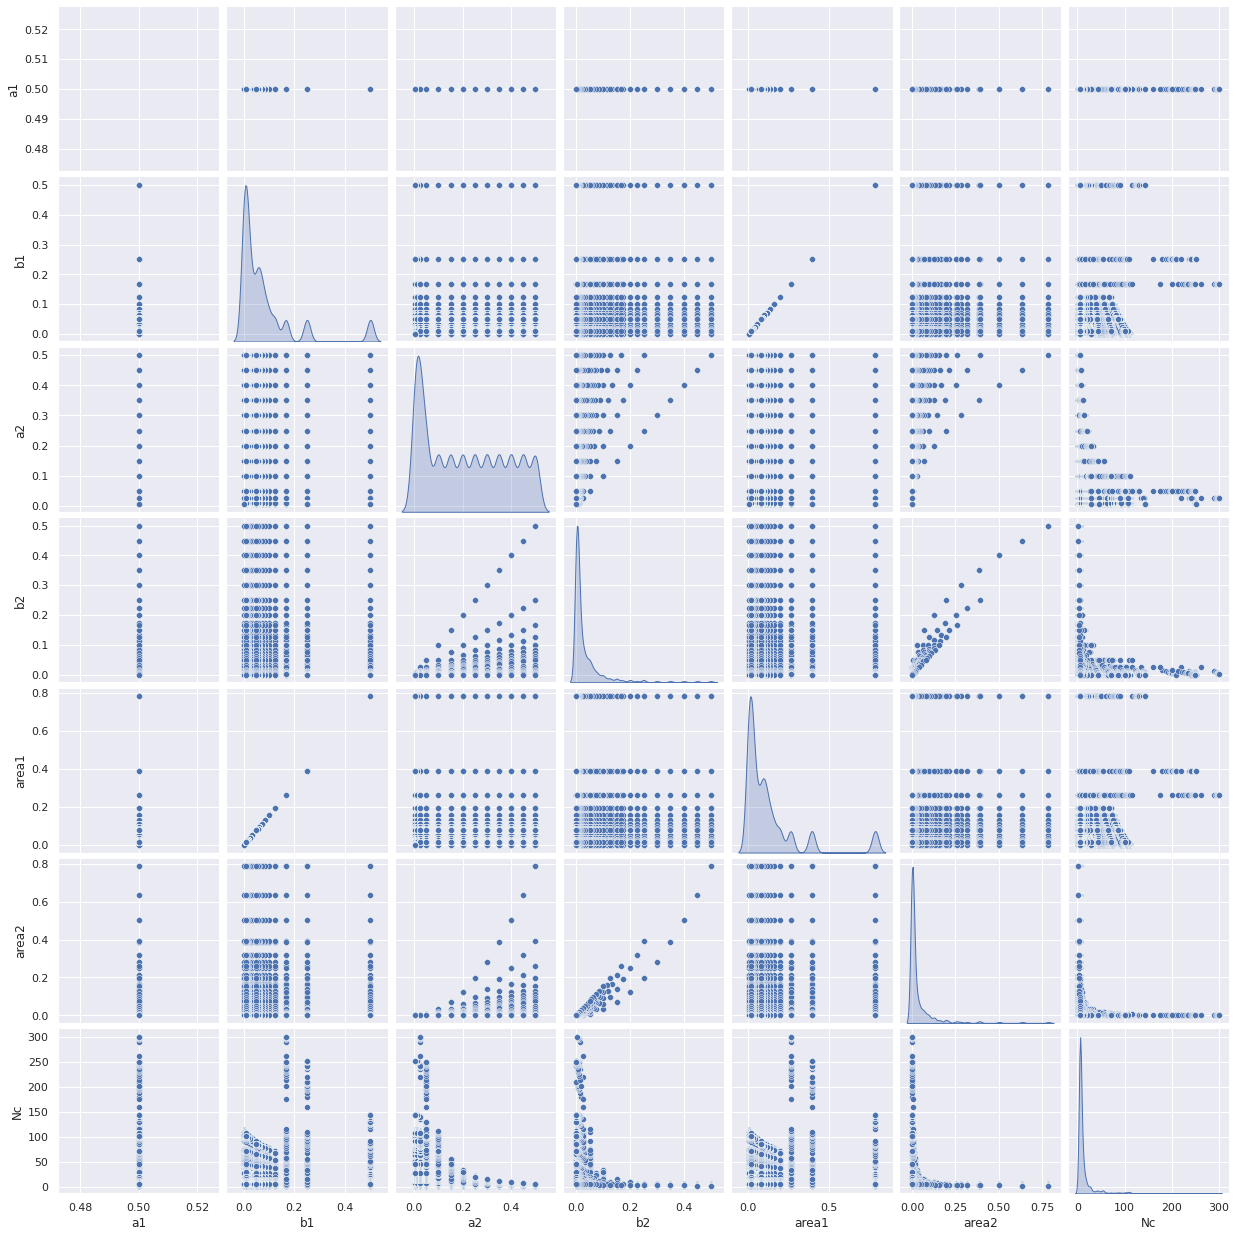

In [ ]:
fig=sns.pairplot(dataset[['a1', 'b1', 'a2', 'b2', 'area1', 'area2', 'Nc']], diag_kind='kde')
# fig.savefig("imgs/expanded_pairplot.png")

The expanded pairplot.

![Pairplot](imgs/expanded_pairplot.png)

In [ ]:
dataset.head()

,r1,2a2,r2,frac,Nc,Nc Std. Dev,eta c,a1,b1,a2,b2,area1,area2,TotalArea,RatioTotalArea
0,1,1.0,1,0.1,1.43561,0.002692,1.12752,0.5,0.5,0.5,0.500000,0.785398,0.785398,1.570796,0.785398
1,1,1.0,1,0.3,1.43786,0.002047,1.12929,0.5,0.5,0.5,0.500000,0.785398,0.785398,1.570796,0.785398
2,1,1.0,2,0.1,1.50315,0.003297,1.12154,0.5,0.5,0.5,0.250000,0.785398,0.392699,1.178097,0.746128
3,1,1.0,2,0.3,1.65310,0.002845,1.10359,0.5,0.5,0.5,0.250000,0.785398,0.392699,1.178097,0.667588
4,1,1.0,3,0.1,1.51915,0.002239,1.11360,0.5,0.5,0.5,0.166667,0.785398,0.261799,1.047198,0.733038


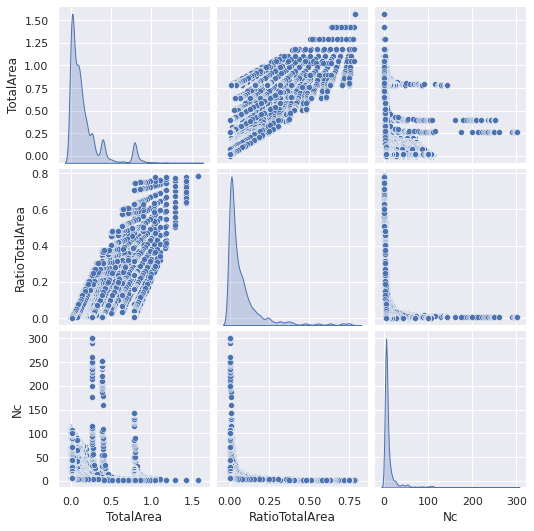

In [ ]:
fig=sns.pairplot(dataset[['TotalArea', 'RatioTotalArea', 'Nc']], diag_kind='kde')

Now the range of each feature is different and some of them are unbalanced. The features can be standardized between -1 and 1 with a 0 mean. This will be useful to prevent one feature from dominating the weight updates. We can account for the unbalancing by ommiting some data and/or feature selection. However, lets try PCA first and see how the problem looks. 

NOTE: The targets 'eta c' and 'Nc' have been scaled.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaled_dataset = dataset.copy()
scaled_dataset['r1'] = StandardScaler().fit_transform(dataset['r1'].values.reshape(-1,1))
scaled_dataset['r2'] = StandardScaler().fit_transform(dataset['r2'].values.reshape(-1,1))
scaled_dataset['frac'] = StandardScaler().fit_transform(dataset['frac'].values.reshape(-1,1))
scaled_dataset['2a2'] = StandardScaler().fit_transform(dataset['a2'].values.reshape(-1,1))
scaled_dataset['eta c'] = StandardScaler().fit_transform(dataset['eta c'].values.reshape(-1,1))
scaled_dataset['Nc'] = StandardScaler().fit_transform(dataset['Nc'].values.reshape(-1,1))

#account for added features
scaled_dataset["a1"]=1/2
scaled_dataset["b1"]=scaled_dataset["a1"]/scaled_dataset["r1"]
scaled_dataset["a2"]=scaled_dataset["2a2"]/2
scaled_dataset["b2"]=scaled_dataset["a2"]/scaled_dataset["r2"]
dataset["area1"]=dataset["a1"]*dataset["b1"]*np.pi
dataset["area2"]=dataset["a2"]*dataset["b2"]*np.pi
scaled_dataset["TotalArea"] = StandardScaler().fit_transform(dataset['TotalArea'].values.reshape(-1,1))
scaled_dataset["RatioTotalArea"] = StandardScaler().fit_transform(dataset['RatioTotalArea'].values.reshape(-1,1))

scaled_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,57841.0,8.408364e-15,1.000009,-4.395904e-01,-0.422416,-0.400948,-0.229206,3.849677
2a2,57841.0,3.084386e-16,1.000009,-1.253563e+00,-0.984867,-0.089215,0.806437,1.702089
r2,57841.0,2.267242e-17,1.000009,-4.424461e-01,-0.425341,-0.403959,-0.232906,3.829597
frac,57841.0,6.800014e-15,1.000009,-1.492678e+00,-1.001370,-0.018754,0.963861,1.586184
Nc,57841.0,1.270110e-15,1.000009,-5.590365e-01,-0.378251,-0.308034,-0.089611,14.444343
Nc Std. Dev,57841.0,1.534408e-02,0.029638,1.055250e-03,0.005530,0.007528,0.012261,0.822712
eta c,57841.0,4.291406e-16,1.000009,-1.236784e+00,-0.906402,-0.104892,0.645064,3.285683
a1,57841.0,5.000000e-01,0.000000,5.000000e-01,0.500000,0.500000,0.500000,0.500000
b1,57841.0,-2.878904e+00,7.280559,-3.441664e+01,-1.396598,-1.208228,-1.148641,1.205318
a2,57841.0,1.542193e-16,0.500004,-6.267814e-01,-0.492434,-0.044608,0.403218,0.851044


In [ ]:
scaled_dataset.head()

,r1,2a2,r2,frac,Nc,Nc Std. Dev,eta c,a1,b1,a2,b2,area1,area2,TotalArea,RatioTotalArea
0,-0.43959,1.702089,-0.442446,-1.328909,-0.559009,0.002692,2.335983,0.5,-1.137422,0.851044,-1.923498,0.785398,0.785398,6.797525,5.846071
1,-0.43959,1.702089,-0.442446,-0.673832,-0.558896,0.002047,2.341613,0.5,-1.137422,0.851044,-1.923498,0.785398,0.785398,6.797525,5.846071
2,-0.43959,1.702089,-0.438170,-1.328909,-0.555619,0.003297,2.316959,0.5,-1.137422,0.851044,-1.942271,0.785398,0.392699,4.897996,5.520644
3,-0.43959,1.702089,-0.438170,-0.673832,-0.548094,0.002845,2.259858,0.5,-1.137422,0.851044,-1.942271,0.785398,0.392699,4.897996,4.869791
4,-0.43959,1.702089,-0.433893,-1.328909,-0.554816,0.002239,2.291701,0.5,-1.137422,0.851044,-1.961413,0.785398,0.261799,4.264820,5.412169


We can visualise the (original) features and targets again to understand the scaling.

In [ ]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(scaled_dataset["eta c"], color='red', bins=100, ax=axs[0])
# sns.distplot(scaled_dataset["Nc"], color='red', bins=100, ax=axs[1])
# fig.savefig("scaled_labels.png")

# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(scaled_dataset["r1"], color='red', bins=1000, ax=axs[0])
# sns.distplot(scaled_dataset["r2"], color='red', bins=1000, ax=axs[1])
# fig.savefig("scaled_r_features.png")

# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(scaled_dataset["frac"], color='red', bins=100, ax=axs[0])
# sns.distplot(scaled_dataset["a2"], color='red', bins=100, ax=axs[1])
# fig.savefig("scaled_frac_a2.png")

# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(scaled_dataset["area1"], color='red', bins=100, ax=axs[0])
# sns.distplot(scaled_dataset["area2"], color='red', bins=100, ax=axs[1])
# fig.savefig("imgs/scaled_areas.png")

The scaled data.

![scaled_r](imgs/scaled_r_features.png)
![scaled_frac](imgs/scaled_frac_a2.png)
![scaled_labels](imgs/scaled_labels.png)
![scaled_areas](imgs/scaled_areas.png)

Here you can clearly see that r1 and r2 have a bias with large outliers. frac and a2 have pretty uniform distributions and can be handled pretty easily by ommiting samples at the lower and higher end. For now I do not think this is necessary because the difference in the number of samples is not huge and will effect the other distributions. eta c still looks like a better label, with a smaller range, fewer outliers and less of a bias than Nc. The area values are positive and kept between 0 and 1 making them a possible set of inputs alongside the fractions. This would give the input feature vector as {area1,area2,frac} and labels as given.

We can look at the covariance matrix of the data, but we know that they were slected relatively independantley. The pairplot and covariance matrix will allow us to check for any easyier representations of the data. 

In [ ]:
scaled_dataset.cov()

,r1,2a2,r2,frac,Nc,Nc Std. Dev,eta c,a1,b1,a2,b2,area1,area2,TotalArea,RatioTotalArea
r1,1.000017,-0.001121,-9.024333e-05,-0.008084,0.035187,0.000189,-0.372151,0.0,0.500009,-0.000560,2.410916e-03,-5.376546e-02,-3.794519e-05,-0.260253,-0.212729
2a2,-0.001121,1.000017,1.822710e-04,0.002518,-0.334472,-0.009139,0.019714,0.0,0.002265,0.500009,-2.467733e+00,4.133497e-05,3.903841e-02,0.189033,0.162966
r2,-0.000090,0.000182,1.000017e+00,-0.000197,0.012111,0.000284,-0.116750,0.0,-0.000369,0.000091,6.375721e-17,-1.314669e-06,-1.543775e-02,-0.074680,-0.064720
frac,-0.008084,0.002518,-1.971446e-04,1.000017,0.457026,0.011455,0.047311,0.0,0.033879,0.001259,-6.920362e-03,7.584916e-03,9.187256e-05,0.037133,-0.218969
Nc,0.035187,-0.334472,1.211080e-02,0.457026,1.000017,0.027797,-0.071311,0.0,-0.122349,-0.167236,8.126895e-01,-9.108798e-03,-1.422518e-02,-0.112869,-0.254533
Nc Std. Dev,0.000189,-0.009139,2.837147e-04,0.011455,0.027797,0.000878,0.000055,0.0,-0.000663,-0.004570,2.252569e-02,1.142194e-04,-3.534956e-04,-0.001157,-0.005861
eta c,-0.372151,0.019714,-1.167498e-01,0.047311,-0.071311,0.000055,1.000017,0.0,1.348565,0.009857,1.884003e-01,1.418262e-01,2.590205e-02,0.811320,0.762428
a1,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
b1,0.500009,0.002265,-3.693916e-04,0.033879,-0.122349,-0.000663,1.348565,0.0,53.006539,0.001133,-6.947519e-03,2.037121e-01,8.591194e-05,0.985793,0.803926
a2,-0.000560,0.500009,9.113552e-05,0.001259,-0.167236,-0.004570,0.009857,0.0,0.001133,0.250004,-1.233866e+00,2.066748e-05,1.951921e-02,0.094517,0.081483


In [ ]:
# C_mat = scaled_dataset.corr()
# fig = plt.figure(figsize = (15,15))

# sns.heatmap(C_mat, vmax = .8, square = True)
# fig.savefig("imgs/corr_map.png")
# plt.show()

From the orginal data, eta c seems to have a negative linear tendency with r1, r2 and 2a2, however its relationship with 2a2 is weak. From the expanded data you can see the strongest correlation with b1, followed by the TotalArea and RatioTotalArea. If we use b1, we will have to use a2/2a2, and b2 with frac in the input space. However, the axis have weak correlations with eta c. If we look at the total area, we see a stong correlation with eta c. This may indicate a good input variable to use. Options can include:
- {frac, TotalArea}
- {RatioTotalArea}
- {TotalArea}
- {frac, RatioTotalArea}

RatioTotalArea has the frac encoded into it while total area does not. It is probably more advisable to use {frac, RatioTotalArea}. I would choose this because there is a strong correlation, RatioTotalArea has area1 and area2 and, thus, r1 and r2 encoded in it. It also has frac, but I may think that having frac explicitly defined in the input is better.  

## Checking the Areas
We will look at a total area and fractional-added total area columns. The data below shows some kind of shape with eta c and the 2 values. This is interesting and may show that using this in the model is useful. 

In [ ]:
# fig=sns.pairplot(scaled_dataset[['TotalArea', 'RatioTotalArea', 'eta c']], diag_kind='kde')
# fig.savefig("imgs/totalareas_pairplot.png")

Pairplot of areas, areas including frac and eta c.

![total_areas](imgs/totalareas_pairplot.png)

## r1 = r2

Here we will look at keeping some variables constant or in a range. For instance, we can keep the frac constant and see how eta c varies with the RatioTotalArea. Another option could be keeping r1 and r2 constant and plotting eta c vs 2 other variables.

We notice similar surfaces when we keep r1 and r2 the same and we notice similar surfaces when r1 and r2 are differet. Could this indicate 2 models? 

In [ ]:
# select the data according to some criterion or criteria
val = 500
selection_dataset = dataset.copy()
select_1 = selection_dataset[dataset["frac"]<2]
select_2 = select_1[select_1["r2"]==val]
select_3 = select_2[select_2["r1"]==val]
final_selection = select_3.copy()

#__________________________________________________________________________________________________________________________________________________________________________________________________________________
# scale the data
final_selection['r1'] = StandardScaler().fit_transform(final_selection['r1'].values.reshape(-1,1))
final_selection['r2'] = StandardScaler().fit_transform(final_selection['r2'].values.reshape(-1,1))
final_selection['frac'] = StandardScaler().fit_transform(final_selection['frac'].values.reshape(-1,1))
final_selection['2a2'] = StandardScaler().fit_transform(final_selection['a2'].values.reshape(-1,1))
final_selection['eta c'] = StandardScaler().fit_transform(final_selection['eta c'].values.reshape(-1,1))
final_selection['Nc'] = StandardScaler().fit_transform(final_selection['Nc'].values.reshape(-1,1))

#account for added features
final_selection['a1'] = StandardScaler().fit_transform(final_selection['a1'].values.reshape(-1,1))
final_selection['b1'] = StandardScaler().fit_transform(final_selection['b1'].values.reshape(-1,1))
final_selection['a2'] = StandardScaler().fit_transform(final_selection['a2'].values.reshape(-1,1))
final_selection['b2'] = StandardScaler().fit_transform(final_selection['b2'].values.reshape(-1,1))
final_selection['area1'] = StandardScaler().fit_transform(final_selection['area1'].values.reshape(-1,1))
final_selection['area2'] = StandardScaler().fit_transform(final_selection['area2'].values.reshape(-1,1))
final_selection["TotalArea"] = StandardScaler().fit_transform(final_selection['TotalArea'].values.reshape(-1,1))
final_selection["RatioTotalArea"] = StandardScaler().fit_transform(final_selection['RatioTotalArea'].values.reshape(-1,1))

#__________________________________________________________________________________________________________________________________________________________________________________________________________________
xaxis_label = "RatioTotalArea"
yaxis_label = "eta c"

title = "Comparing {x} and {y}".format(x=xaxis_label, y=yaxis_label)
# plt.scatter(x=np.arange(len(final_selection)), y=final_selection[yaxis_label], marker='.')
fig = plt.figure(figsize=(10,10))
plt.scatter(x=final_selection[xaxis_label], y=final_selection[yaxis_label], marker='.')
plt.ylabel(yaxis_label)
plt.xlabel(xaxis_label)
plt.title(title)
# fig.savefig("imgs/edited_data/r1_r2_{}.png".format(val))

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

z = "eta c"
y = "frac"
x = "2a2"

zdata =  select_3[z]
ydata =  select_3[y]
xdata = select_3[x]
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds');
# ax.plot3D(xdata, ydata, zdata, 'gray')
ax.scatter3D(xdata, ydata, zdata);
plt.ylabel(y)
plt.xlabel(x)
# fig.savefig("imgs/edited_data/3d_r1_r2_{}.png".format(val))
# plt.zlabel("eta c")

After plotting the data with r1=r2 you can see similar shapes in the 3d plots were {x,y,z}={2a2,frac,eta c}. This is encouraging because it shows that for the data where r1 and r2 are equal, we can create a ML algo to learn that 3D shape, hopefully producing the correct eta c output. Similarly, if you plot {x,y}={RatioTotalArea, eta c} you can similar curves for each r1=r2 pair. The data may be slightly differently spread, but this is okay. Possibly doing a 3D surface like for the other will allow a surface ot be learnt, however, the {x,y,z}={2a2,frac,eta c} plot shows that this may be irrelevant for the r1=r2 values, because we can learn from the given data without need for the expanded data. Now we need to check for the data where r1!=r2. Previously I looked at it and a simialr shape could be seen (but with more fluctation between the values). However, I cannot remember if the shape was simialr to the r1=r2 shape. We will check these below. 

The 3D curve shows how eta c varies with 2a2 and frac. Out of the entire data set, r1=r2 accounts for 2892 of 57840, or 5%. 

In [ ]:
# r1_new_range = single_input_vs_output(final_selection, "r1")
dataset[dataset["r1"]< dataset["r2"]].count()
# dataset[dataset["r1"]<150].count()["r1"]

## r1 != r2
Here, we will do a similar thing to above but for the majority of the data were r1 != r2. We will not look at all of the data, but rather 4 from each. 

After plotting the data for this,some similar shapes were seen both within a set and across sets with similar r2 values. 

In [ ]:
x = [1,2,3,4]
y = [5,10,15,20]
z = [2, 6, 4, 8]
colors = ['blue', 'green', 'magenta', 'orange']
colour_selector = 0

fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection='3d')
for i in range(0, len(x)):
    ax.scatter3D(x[i], y[i], z[i], c=colors[colour_selector])
    colour_selector+=1

In [ ]:
plt.ioff()

colors = ['blue', 'green', 'magenta', 'orange']
# colors = ['green', 'blue', 'orange', 'magenta']

ii_prev = -1
choose_set = -1
# this loop runs for each r1, giving r1=x and r2=[x1,x2,x3,x4]
for ii in range(0,20):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    z = "eta c"
    y = "frac"
    x = "2a2"
    # selector needs to go from 0-19 (20 values in r1_range)
    if ii_prev==4:
        choose_set = 0
    else:
        choose_set += 1
    ii_prev = choose_set

    selector = np.arange(5,21,5)-choose_set-1     # gives [5,10,15,20] - choose_set

    colour_selector = 0
    for i in selector:
        # selects the r1 value 
        val = (r1_range["r1"].to_numpy())[ii] 
        val2 = (r2_range["r2"].to_numpy())[i]

        # selects the data sets
        selection_dataset = dataset.copy()
        # filters the data to the chosen r1 value (outer loop)
        select_1 = selection_dataset[selection_dataset["r1"]==val]
        # filters the data to the chosen r2 value (inner loop, so 1 of 4)
        select_2 = select_1[select_1["r2"]==val2]
        
        final_selection = select_2
        # scale the data
        final_selection['r1'] = StandardScaler().fit_transform(final_selection['r1'].values.reshape(-1,1))
        final_selection['r2'] = StandardScaler().fit_transform(final_selection['r2'].values.reshape(-1,1))
        final_selection['frac'] = StandardScaler().fit_transform(final_selection['frac'].values.reshape(-1,1))
        final_selection['2a2'] = StandardScaler().fit_transform(final_selection['a2'].values.reshape(-1,1))
        final_selection['eta c'] = StandardScaler().fit_transform(final_selection['eta c'].values.reshape(-1,1))

        # plots the data for each 
        zdata =  final_selection[z]
        ydata =  final_selection[y]
        xdata = final_selection[x]
        ax.scatter3D(xdata, ydata, zdata, c=colors[colour_selector-1])
        colour_selector+=1
    
    title = "Comparing r1={x} and r2={y}".format(x=val, y=str(selector))
    plt.ylabel(y)
    plt.xlabel(x)
    plt.title(title)
    fig.savefig("/diff r1 and r2/r1_{x}.png".format(x=val))
    plt.close(fig)
    # plt.zlabel("eta c")

## RatioTotalArea and frac
Here we will plot the RatioTotalArea vs eta c for different frac. Thus, {x,y,z} = {RatioTotalArea,frac,eta c}. We will select the data depending on the frarc values and plot the area vs eta c.

In [ ]:
frac_values = [1,3,5,7,9]
ls = []
for i in frac_values:
    ls.append((frac_range["frac"].to_numpy()[i]))

colors = ['blue', 'green', 'magenta', 'orange', 'red']
colour_selector = 0
fig = plt.figure()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
y = "eta c"
x = "RatioTotalArea"
for i in ls:
    val = i

    selection_dataset = dataset.copy()
    select_1 = selection_dataset[selection_dataset["frac"]==val]

    final_selection = select_1
    # scale the data   
    final_selection['frac'] = StandardScaler().fit_transform(final_selection['frac'].values.reshape(-1,1))
    final_selection['eta c'] = StandardScaler().fit_transform(final_selection['eta c'].values.reshape(-1,1))
    final_selection['RatioTotalArea'] = StandardScaler().fit_transform(final_selection['RatioTotalArea'].values.reshape(-1,1))

    xdata = "RatioTotalArea"
    ydata = "eta c"
    title = "frac={frac_vals}".format(frac_vals=val)

    # uncomment next two lines to plot seperate and comment 'fig=...' above
    # fig = plt.figure(figsize=(5,5))
    # title = "{x} vs {y} for frac={frac_vals}".format(x=xdata, y=ydata, frac_vals=val)

    # plots the data for each 
    # plt.scatter(x=final_selection[xdata], y=final_selection[ydata], marker='.', c=colors[colour_selector-1])
    ax[int(colour_selector/3)][colour_selector%3].scatter(x=final_selection[xdata], y=final_selection[ydata], marker='.', c=colors[colour_selector-1])
    ax[1][2].scatter(x=final_selection[xdata], y=final_selection[ydata], marker='.', c=colors[colour_selector-1], alpha=0.1)
    # ax[int(colour_selector/3)][colour_selector%3].set_ylabel(ydata)
    # ax[int(colour_selector/3)][colour_selector%3].set_xlabel(xdata)
    ax[int(colour_selector/3)][colour_selector%3].set_title(title)
    colour_selector+=1

title = "{x} vs {y} for frac={frac_vals}".format(x=xdata, y=ydata, frac_vals=ls)
ax[0][0].set_ylabel(ydata)
ax[1][0].set_ylabel(ydata)
ax[1][0].set_xlabel(xdata)
ax[1][1].set_xlabel(xdata)
ax[1][2].set_xlabel(xdata)
ax[1][2].set_title(title)
# fig.savefig("/RTA_diff_frac.png")

From this we can see the spread increases as the fraction is increases. If we use area, fraction is definitely important as well.

The data distribution is still not good for most, so it seems like using the area is our best bet for now. Going back to the pairplot, we can see that a lot of the data is clumped in the <0.5 area range for both ellipse 1 and 2. Maybe we can try splitting this and only including for the areas <0.5 and testing a trained model on this, to start. 

Doint this may reduce the dataset substantially because there is not correlation between the two.

In [ ]:
# drop_areas_scaled_dataset = scaled_dataset.copy()

# drop_areas_scaled_dataset.drop(drop_areas_scaled_dataset[drop_areas_scaled_dataset.area1 > 0.55].index, inplace=True)
# drop_areas_scaled_dataset.drop(drop_areas_scaled_dataset[drop_areas_scaled_dataset.area2 > 0.55].index, inplace=True)
# drop_areas_scaled_dataset.describe().transpose()

# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.distplot(drop_areas_scaled_dataset["area1"], color='red', bins=100, ax=axs[0])
# sns.distplot(drop_areas_scaled_dataset["area2"], color='red', bins=100, ax=axs[1])

## PCA

Now we will implement PCA to try and reduce the number of input features. The total number of un expanded features is 4. With the expansion, we get 8. First we will try PCA on the 4, then the 8 and then maybe a selection of the features. For now the labels will be the nonstandardizedd 'eta c'. In the future we can possibly use both 'eta c' and 'Nc' or their scaled versions. 

In [ ]:
from sklearn.decomposition import PCA

features = scaled_dataset.drop(['eta c', 'Nc', 'Nc Std. Dev', 'a1', 'b1', 'a2', 'b2'], axis=1)
expanded_features = scaled_dataset.drop(['eta c', 'Nc', 'Nc Std. Dev',], axis=1)
labels = scaled_dataset['eta c']

components = 2
components_cols = ['PC 1', 'PC 2']
X = features
Y = labels

pca = PCA(n_components=components)
pca_data = pca.fit_transform(X.values)

principalDf = pd.DataFrame(data = pca_data, columns = components_cols)

pcaDF = pd.concat([principalDf, Y], axis = 1)
pcaDF.head()

In [ ]:
# fig, axs = plt.subplots(ncols=1, figsize=(12,6))
# sns.distplot(scaled_dataset["frac"], color='red', bins=100, ax=axs[0])
# sns.distplot(scaled_dataset["a2"], color='red', bins=100, ax=axs[1])
fig = sns.pairplot(pcaDF[['PC 1', 'PC 2', 'eta c']], diag_kind='kde')
fig.savefig("imgs/PCA.png")


The PCA data has been plotted in a pair plot to see how the new components relate to the output. 

![pca](imgs/PCA.png)

An attempt with 1 component.

In [ ]:
components = 1
components_cols = ['PC 1']
X = features
Y = labels

pca = PCA(n_components=components)
pca_data = pca.fit_transform(X.values)

principalDf = pd.DataFrame(data = pca_data, columns = components_cols)

pcaDF = pd.concat([principalDf, Y], axis = 1)
pcaDF.head()

In [ ]:
fig = sns.pairplot(pcaDF[['PC 1', 'eta c']], diag_kind='kde')
fig.savefig("OnePCA.png")

Lastly, we will store the dataframes to csv files to be used in other notebooks.

In [ ]:
scaled_dataset.to_csv("NormalizedData.csv")

In [ ]:
pcaDF.to_csv("PCA")